In [210]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

In [211]:
# Configuration
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [212]:
dataset_path = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.ckpt'
NUM_CLASSES = 4

In [213]:
# Load dataset
X = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, 21 * 2 + 1)))
y = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

In [214]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

In [215]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128)

In [216]:
from torchmetrics.classification import Accuracy


In [217]:
# Lightning module
class KeypointClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(21 * 2, 20),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, NUM_CLASSES)
        )
        self.accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [218]:
# Initialize model
model = KeypointClassifier()

In [219]:
# Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='model/keypoint_classifier/',
    filename='keypoint_classifier',
    save_top_k=1,
    monitor='val_loss',
    mode='min'
)

In [220]:
# Trainer
trainer = pl.Trainer(
    max_epochs=1000,
    callbacks=[early_stop_callback, checkpoint_callback],
    deterministic=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [221]:
# Train the model
trainer.fit(model, train_loader, val_loader)

C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\houci\Documents\ENSAM\3eme annee\S6\Computer Vision\hand-gesture-recognition-mediapipe-main\model\keypoint_classifier exists and is not empty.

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 1.1 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|█████████████████████████████████████████████| 21/21 [00:00<00:00, 67.15it/s, v_num=11, train_acc=0.0755]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|█████████████████████████████| 21/21 [00:00<00:00, 46.40it/s, v_num=11, train_acc=0.0755, val_acc=0.0482]

Metric val_loss improved. New best score: 1.454


Epoch 1: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.03it/s, v_num=11, train_acc=0.189, val_acc=0.0482]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████| 21/21 [00:00<00:00, 48.93it/s, v_num=11, train_acc=0.189, val_acc=0.358]

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 1.337


Epoch 2: 100%|███████████████████████████████| 21/21 [00:00<00:00, 58.36it/s, v_num=11, train_acc=0.340, val_acc=0.358]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████████████| 21/21 [00:00<00:00, 42.08it/s, v_num=11, train_acc=0.340, val_acc=0.404]

Metric val_loss improved by 0.164 >= min_delta = 0.0. New best score: 1.174


Epoch 3: 100%|███████████████████████████████| 21/21 [00:00<00:00, 58.07it/s, v_num=11, train_acc=0.509, val_acc=0.404]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|███████████████████████████████| 21/21 [00:00<00:00, 43.50it/s, v_num=11, train_acc=0.509, val_acc=0.679]

Metric val_loss improved by 0.143 >= min_delta = 0.0. New best score: 1.031


Epoch 4: 100%|███████████████████████████████| 21/21 [00:00<00:00, 67.73it/s, v_num=11, train_acc=0.604, val_acc=0.679]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|███████████████████████████████| 21/21 [00:00<00:00, 48.78it/s, v_num=11, train_acc=0.604, val_acc=0.639]

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.944


Epoch 5: 100%|███████████████████████████████| 21/21 [00:00<00:00, 67.73it/s, v_num=11, train_acc=0.566, val_acc=0.639]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███████████████████████████████| 21/21 [00:00<00:00, 47.98it/s, v_num=11, train_acc=0.566, val_acc=0.725]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.874


Epoch 6: 100%|███████████████████████████████| 21/21 [00:00<00:00, 67.67it/s, v_num=11, train_acc=0.604, val_acc=0.725]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|███████████████████████████████| 21/21 [00:00<00:00, 49.63it/s, v_num=11, train_acc=0.604, val_acc=0.742]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.813


Epoch 7: 100%|███████████████████████████████| 21/21 [00:00<00:00, 67.55it/s, v_num=11, train_acc=0.604, val_acc=0.742]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|███████████████████████████████| 21/21 [00:00<00:00, 49.16it/s, v_num=11, train_acc=0.604, val_acc=0.774]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.753


Epoch 8: 100%|███████████████████████████████| 21/21 [00:00<00:00, 70.28it/s, v_num=11, train_acc=0.717, val_acc=0.774]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|███████████████████████████████| 21/21 [00:00<00:00, 50.83it/s, v_num=11, train_acc=0.717, val_acc=0.783]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.693


Epoch 9: 100%|███████████████████████████████| 21/21 [00:00<00:00, 67.86it/s, v_num=11, train_acc=0.660, val_acc=0.783]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|███████████████████████████████| 21/21 [00:00<00:00, 48.87it/s, v_num=11, train_acc=0.660, val_acc=0.799]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.636


Epoch 10: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.84it/s, v_num=11, train_acc=0.660, val_acc=0.799]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.00it/s, v_num=11, train_acc=0.660, val_acc=0.815]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.587


Epoch 11: 100%|██████████████████████████████| 21/21 [00:00<00:00, 67.29it/s, v_num=11, train_acc=0.698, val_acc=0.815]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.67it/s, v_num=11, train_acc=0.698, val_acc=0.837]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.540


Epoch 12: 100%|██████████████████████████████| 21/21 [00:00<00:00, 71.00it/s, v_num=11, train_acc=0.736, val_acc=0.837]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.47it/s, v_num=11, train_acc=0.736, val_acc=0.825]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.502


Epoch 13: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.86it/s, v_num=11, train_acc=0.792, val_acc=0.825]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.43it/s, v_num=11, train_acc=0.792, val_acc=0.900]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.471


Epoch 14: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.42it/s, v_num=11, train_acc=0.774, val_acc=0.900]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.17it/s, v_num=11, train_acc=0.774, val_acc=0.913]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.441


Epoch 15: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.90it/s, v_num=11, train_acc=0.792, val_acc=0.913]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.88it/s, v_num=11, train_acc=0.792, val_acc=0.921]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.417


Epoch 16: 100%|██████████████████████████████| 21/21 [00:00<00:00, 65.49it/s, v_num=11, train_acc=0.679, val_acc=0.921]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████████████████████████| 21/21 [00:00<00:00, 47.06it/s, v_num=11, train_acc=0.679, val_acc=0.920]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.399


Epoch 17: 100%|██████████████████████████████| 21/21 [00:00<00:00, 63.31it/s, v_num=11, train_acc=0.755, val_acc=0.920]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████████████████████████| 21/21 [00:00<00:00, 47.18it/s, v_num=11, train_acc=0.755, val_acc=0.924]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.382


Epoch 18: 100%|██████████████████████████████| 21/21 [00:00<00:00, 57.05it/s, v_num=11, train_acc=0.717, val_acc=0.924]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████████████████████████| 21/21 [00:00<00:00, 34.48it/s, v_num=11, train_acc=0.717, val_acc=0.922]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.368


Epoch 19: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.40it/s, v_num=11, train_acc=0.717, val_acc=0.922]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.16it/s, v_num=11, train_acc=0.717, val_acc=0.920]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.353


Epoch 20: 100%|██████████████████████████████| 21/21 [00:00<00:00, 65.47it/s, v_num=11, train_acc=0.868, val_acc=0.920]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████████████████████████| 21/21 [00:00<00:00, 47.16it/s, v_num=11, train_acc=0.868, val_acc=0.917]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.339


Epoch 21: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.49it/s, v_num=11, train_acc=0.717, val_acc=0.917]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████████████████████████| 21/21 [00:00<00:00, 47.90it/s, v_num=11, train_acc=0.717, val_acc=0.920]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.331


Epoch 22: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.94it/s, v_num=11, train_acc=0.717, val_acc=0.920]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.14it/s, v_num=11, train_acc=0.717, val_acc=0.921]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.320


Epoch 23: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.85it/s, v_num=11, train_acc=0.660, val_acc=0.921]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.74it/s, v_num=11, train_acc=0.660, val_acc=0.924]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.315


Epoch 24: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.07it/s, v_num=11, train_acc=0.792, val_acc=0.924]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.48it/s, v_num=11, train_acc=0.792, val_acc=0.924]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.306


Epoch 25: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.99it/s, v_num=11, train_acc=0.774, val_acc=0.924]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.22it/s, v_num=11, train_acc=0.774, val_acc=0.927]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.297


Epoch 26: 100%|██████████████████████████████| 21/21 [00:00<00:00, 67.83it/s, v_num=11, train_acc=0.811, val_acc=0.927]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████████████████████████| 21/21 [00:00<00:00, 47.77it/s, v_num=11, train_acc=0.811, val_acc=0.919]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.294


Epoch 27: 100%|██████████████████████████████| 21/21 [00:00<00:00, 67.69it/s, v_num=11, train_acc=0.736, val_acc=0.919]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.23it/s, v_num=11, train_acc=0.736, val_acc=0.923]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.284


Epoch 28: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.14it/s, v_num=11, train_acc=0.774, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.63it/s, v_num=11, train_acc=0.774, val_acc=0.927]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.282


Epoch 29: 100%|██████████████████████████████| 21/21 [00:00<00:00, 55.92it/s, v_num=11, train_acc=0.887, val_acc=0.927]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████████████████████████| 21/21 [00:00<00:00, 41.13it/s, v_num=11, train_acc=0.887, val_acc=0.923]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.274


Epoch 30: 100%|██████████████████████████████| 21/21 [00:00<00:00, 52.23it/s, v_num=11, train_acc=0.849, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████████████████████████| 21/21 [00:00<00:00, 37.93it/s, v_num=11, train_acc=0.849, val_acc=0.932]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.268


Epoch 31: 100%|██████████████████████████████| 21/21 [00:00<00:00, 64.43it/s, v_num=11, train_acc=0.792, val_acc=0.932]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████████████████████████| 21/21 [00:00<00:00, 46.44it/s, v_num=11, train_acc=0.792, val_acc=0.929]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.263


Epoch 32: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.97it/s, v_num=11, train_acc=0.698, val_acc=0.929]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.84it/s, v_num=11, train_acc=0.698, val_acc=0.929]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.260


Epoch 33: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.08it/s, v_num=11, train_acc=0.811, val_acc=0.929]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.82it/s, v_num=11, train_acc=0.811, val_acc=0.925]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.255


Epoch 34: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.84it/s, v_num=11, train_acc=0.792, val_acc=0.925]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.52it/s, v_num=11, train_acc=0.792, val_acc=0.927]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.254


Epoch 35: 100%|██████████████████████████████| 21/21 [00:00<00:00, 65.89it/s, v_num=11, train_acc=0.755, val_acc=0.927]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.45it/s, v_num=11, train_acc=0.755, val_acc=0.933]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.250


Epoch 36: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.19it/s, v_num=11, train_acc=0.811, val_acc=0.933]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.74it/s, v_num=11, train_acc=0.811, val_acc=0.933]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.246


Epoch 37: 100%|██████████████████████████████| 21/21 [00:00<00:00, 65.22it/s, v_num=11, train_acc=0.849, val_acc=0.933]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.22it/s, v_num=11, train_acc=0.849, val_acc=0.933]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.240


Epoch 38: 100%|██████████████████████████████| 21/21 [00:00<00:00, 67.37it/s, v_num=11, train_acc=0.792, val_acc=0.933]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.92it/s, v_num=11, train_acc=0.792, val_acc=0.932]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.237


Epoch 39: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.55it/s, v_num=11, train_acc=0.774, val_acc=0.932]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.86it/s, v_num=11, train_acc=0.792, val_acc=0.936]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████████████████████████| 21/21 [00:00<00:00, 73.18it/s, v_num=11, train_acc=0.774, val_acc=0.936]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████████████████████████| 21/21 [00:00<00:00, 52.40it/s, v_num=11, train_acc=0.774, val_acc=0.940]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.231


Epoch 42: 100%|██████████████████████████████| 21/21 [00:00<00:00, 72.87it/s, v_num=11, train_acc=0.830, val_acc=0.940]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████████████████████████| 21/21 [00:00<00:00, 52.37it/s, v_num=11, train_acc=0.830, val_acc=0.943]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.226


Epoch 43: 100%|██████████████████████████████| 21/21 [00:00<00:00, 73.06it/s, v_num=11, train_acc=0.868, val_acc=0.943]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████████████████████████| 21/21 [00:00<00:00, 52.10it/s, v_num=11, train_acc=0.868, val_acc=0.942]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.223


Epoch 44: 100%|██████████████████████████████| 21/21 [00:00<00:00, 67.36it/s, v_num=11, train_acc=0.868, val_acc=0.942]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.34it/s, v_num=11, train_acc=0.868, val_acc=0.937]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.220


Epoch 45: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.60it/s, v_num=11, train_acc=0.811, val_acc=0.937]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.27it/s, v_num=11, train_acc=0.792, val_acc=0.935]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.29it/s, v_num=11, train_acc=0.811, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.90it/s, v_num=11, train_acc=0.811, val_acc=0.937]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.215


Epoch 48: 100%|██████████████████████████████| 21/21 [00:00<00:00, 71.35it/s, v_num=11, train_acc=0.774, val_acc=0.937]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████████████████████████| 21/21 [00:00<00:00, 71.15it/s, v_num=11, train_acc=0.849, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.56it/s, v_num=11, train_acc=0.849, val_acc=0.939]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.64it/s, v_num=11, train_acc=0.849, val_acc=0.948]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.212


Epoch 51: 100%|██████████████████████████████| 21/21 [00:00<00:00, 65.53it/s, v_num=11, train_acc=0.849, val_acc=0.948]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.68it/s, v_num=11, train_acc=0.849, val_acc=0.945]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.208


Epoch 52: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.55it/s, v_num=11, train_acc=0.811, val_acc=0.945]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.31it/s, v_num=11, train_acc=0.811, val_acc=0.951]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.205


Epoch 53: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.75it/s, v_num=11, train_acc=0.811, val_acc=0.951]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.50it/s, v_num=11, train_acc=0.811, val_acc=0.942]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.203


Epoch 54: 100%|██████████████████████████████| 21/21 [00:00<00:00, 72.60it/s, v_num=11, train_acc=0.755, val_acc=0.942]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 55: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.47it/s, v_num=11, train_acc=0.906, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 55: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.09it/s, v_num=11, train_acc=0.906, val_acc=0.956]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.201


Epoch 56: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.13it/s, v_num=11, train_acc=0.811, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.51it/s, v_num=11, train_acc=0.811, val_acc=0.955]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.200


Epoch 57: 100%|██████████████████████████████| 21/21 [00:00<00:00, 64.49it/s, v_num=11, train_acc=0.830, val_acc=0.955]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|██████████████████████████████| 21/21 [00:00<00:00, 46.26it/s, v_num=11, train_acc=0.830, val_acc=0.960]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.198


Epoch 58: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.70it/s, v_num=11, train_acc=0.830, val_acc=0.960]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.45it/s, v_num=11, train_acc=0.830, val_acc=0.955]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.194


Epoch 59: 100%|██████████████████████████████| 21/21 [00:00<00:00, 64.97it/s, v_num=11, train_acc=0.849, val_acc=0.955]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████████████████████████| 21/21 [00:00<00:00, 48.29it/s, v_num=11, train_acc=0.849, val_acc=0.952]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.190


Epoch 60: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.05it/s, v_num=11, train_acc=0.755, val_acc=0.952]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 61: 100%|██████████████████████████████| 21/21 [00:00<00:00, 71.46it/s, v_num=11, train_acc=0.792, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.93it/s, v_num=11, train_acc=0.868, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 63: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.67it/s, v_num=11, train_acc=0.887, val_acc=0.951]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 63: 100%|█████████████████████████

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.190


Epoch 64: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.69it/s, v_num=11, train_acc=0.830, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|██████████████████████████████| 21/21 [00:00<00:00, 63.44it/s, v_num=11, train_acc=0.943, val_acc=0.960]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|██████████████████████████████| 21/21 [00:00<00:00, 46.86it/s, v_num=11, train_acc=0.943, val_acc=0.962]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.188


Epoch 66: 100%|██████████████████████████████| 21/21 [00:00<00:00, 64.27it/s, v_num=11, train_acc=0.849, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 66: 100%|██████████████████████████████| 21/21 [00:00<00:00, 47.75it/s, v_num=11, train_acc=0.849, val_acc=0.956]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.183


Epoch 67: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.69it/s, v_num=11, train_acc=0.792, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 67: 100%|██████████████████████████████| 21/21 [00:00<00:00, 51.17it/s, v_num=11, train_acc=0.792, val_acc=0.962]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.182


Epoch 68: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.49it/s, v_num=11, train_acc=0.774, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.37it/s, v_num=11, train_acc=0.925, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|██████████████████████████████| 21/21 [00:00<00:00, 51.29it/s, v_num=11, train_acc=0.925, val_acc=0.961]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.179


Epoch 70: 100%|██████████████████████████████| 21/21 [00:00<00:00, 71.90it/s, v_num=11, train_acc=0.925, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.88it/s, v_num=11, train_acc=0.736, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████████████████████████| 21/21 [00:00<00:00, 51.18it/s, v_num=11, train_acc=0.736, val_acc=0.964]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.179


Epoch 72: 100%|██████████████████████████████| 21/21 [00:00<00:00, 67.72it/s, v_num=11, train_acc=0.811, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 72: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.14it/s, v_num=11, train_acc=0.811, val_acc=0.963]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.176


Epoch 73: 100%|██████████████████████████████| 21/21 [00:00<00:00, 67.96it/s, v_num=11, train_acc=0.868, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.82it/s, v_num=11, train_acc=0.887, val_acc=0.960]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.29it/s, v_num=11, train_acc=0.887, val_acc=0.964]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.170


Epoch 75: 100%|██████████████████████████████| 21/21 [00:00<00:00, 71.58it/s, v_num=11, train_acc=0.868, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.89it/s, v_num=11, train_acc=0.830, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.38it/s, v_num=11, train_acc=0.830, val_acc=0.970]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.168


Epoch 77: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.81it/s, v_num=11, train_acc=0.830, val_acc=0.970]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.30it/s, v_num=11, train_acc=0.811, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 79: 100%|██████████████████████████████| 21/21 [00:00<00:00, 54.83it/s, v_num=11, train_acc=0.849, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 80: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.95it/s, v_num=11, train_acc=0.925, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 80: 100%|█████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.166


Epoch 81: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.35it/s, v_num=11, train_acc=0.868, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 81: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.81it/s, v_num=11, train_acc=0.868, val_acc=0.964]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.165


Epoch 82: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.26it/s, v_num=11, train_acc=0.906, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 82: 100%|██████████████████████████████| 21/21 [00:00<00:00, 49.42it/s, v_num=11, train_acc=0.906, val_acc=0.963]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.163


Epoch 83: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.87it/s, v_num=11, train_acc=0.906, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 84: 100%|██████████████████████████████| 21/21 [00:00<00:00, 68.98it/s, v_num=11, train_acc=0.868, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 85: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.74it/s, v_num=11, train_acc=0.887, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 86: 100%|██████████████████████████████| 21/21 [00:00<00:00, 71.17it/s, v_num=11, train_acc=0.774, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 87: 100%|█████████████████████████

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.159


Epoch 88: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.98it/s, v_num=11, train_acc=0.906, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 89: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.16it/s, v_num=11, train_acc=0.811, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 90: 100%|██████████████████████████████| 21/21 [00:00<00:00, 66.87it/s, v_num=11, train_acc=0.906, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 91: 100%|██████████████████████████████| 21/21 [00:00<00:00, 69.11it/s, v_num=11, train_acc=0.849, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 92: 100%|█████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.158


Epoch 97: 100%|██████████████████████████████| 21/21 [00:00<00:00, 71.15it/s, v_num=11, train_acc=0.868, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.68it/s, v_num=11, train_acc=0.849, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.92it/s, v_num=11, train_acc=0.849, val_acc=0.964]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.158


Epoch 99: 100%|██████████████████████████████| 21/21 [00:00<00:00, 70.40it/s, v_num=11, train_acc=0.849, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████████████████████████| 21/21 [00:00<00:00, 50.46it/s, v_num=11, train_acc=0.849, val_acc=0.964]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.155


Epoch 100: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.13it/s, v_num=11, train_acc=0.792, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|█████████████████████████████| 21/21 [00:00<00:00, 72.53it/s, v_num=11, train_acc=0.830, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 101: 100%|█████████████████████████████| 21/21 [00:00<00:00, 52.34it/s, v_num=11, train_acc=0.830, val_acc=0.963]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.155


Epoch 102: 100%|█████████████████████████████| 21/21 [00:00<00:00, 67.02it/s, v_num=11, train_acc=0.774, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 102: 100%|█████████████████████████████| 21/21 [00:00<00:00, 49.05it/s, v_num=11, train_acc=0.774, val_acc=0.964]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.149


Epoch 103: 100%|█████████████████████████████| 21/21 [00:00<00:00, 66.86it/s, v_num=11, train_acc=0.792, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 104: 100%|█████████████████████████████| 21/21 [00:00<00:00, 66.32it/s, v_num=11, train_acc=0.849, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 104: 100%|█████████████████████████████| 21/21 [00:00<00:00, 48.46it/s, v_num=11, train_acc=0.849, val_acc=0.966]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.146


Epoch 105: 100%|█████████████████████████████| 21/21 [00:00<00:00, 66.79it/s, v_num=11, train_acc=0.906, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 106: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.69it/s, v_num=11, train_acc=0.849, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|█████████████████████████████| 21/21 [00:00<00:00, 73.63it/s, v_num=11, train_acc=0.868, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|█████████████████████████████| 21/21 [00:00<00:00, 52.98it/s, v_num=11, train_acc=0.868, val_acc=0.968]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.145


Epoch 108: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.82it/s, v_num=11, train_acc=0.849, val_acc=0.968]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 108: 100%|█████████████████████████████| 21/21 [00:00<00:00, 52.09it/s, v_num=11, train_acc=0.849, val_acc=0.964]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.144


Epoch 109: 100%|█████████████████████████████| 21/21 [00:00<00:00, 71.37it/s, v_num=11, train_acc=0.755, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 109: 100%|█████████████████████████████| 21/21 [00:00<00:00, 51.67it/s, v_num=11, train_acc=0.755, val_acc=0.968]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.141


Epoch 110: 100%|█████████████████████████████| 21/21 [00:00<00:00, 69.62it/s, v_num=11, train_acc=0.943, val_acc=0.968]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 111: 100%|█████████████████████████████| 21/21 [00:00<00:00, 67.72it/s, v_num=11, train_acc=0.887, val_acc=0.972]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 112: 100%|█████████████████████████████| 21/21 [00:00<00:00, 68.26it/s, v_num=11, train_acc=0.906, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 113: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.04it/s, v_num=11, train_acc=0.906, val_acc=0.968]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 114: 100%|████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.139


Epoch 116: 100%|█████████████████████████████| 21/21 [00:00<00:00, 47.82it/s, v_num=11, train_acc=0.868, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 116: 100%|█████████████████████████████| 21/21 [00:00<00:00, 36.86it/s, v_num=11, train_acc=0.868, val_acc=0.966]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.137


Epoch 117: 100%|█████████████████████████████| 21/21 [00:00<00:00, 60.32it/s, v_num=11, train_acc=0.887, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 117: 100%|█████████████████████████████| 21/21 [00:00<00:00, 33.52it/s, v_num=11, train_acc=0.887, val_acc=0.969]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.131


Epoch 118: 100%|█████████████████████████████| 21/21 [00:00<00:00, 48.51it/s, v_num=11, train_acc=0.868, val_acc=0.969]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 119: 100%|█████████████████████████████| 21/21 [00:00<00:00, 49.65it/s, v_num=11, train_acc=0.868, val_acc=0.972]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 120: 100%|█████████████████████████████| 21/21 [00:00<00:00, 57.44it/s, v_num=11, train_acc=0.792, val_acc=0.970]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 121: 100%|█████████████████████████████| 21/21 [00:00<00:00, 53.85it/s, v_num=11, train_acc=0.811, val_acc=0.968]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 122: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.130


Epoch 128: 100%|█████████████████████████████| 21/21 [00:00<00:00, 42.45it/s, v_num=11, train_acc=0.906, val_acc=0.974]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 129: 100%|█████████████████████████████| 21/21 [00:00<00:00, 68.59it/s, v_num=11, train_acc=0.943, val_acc=0.969]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 129: 100%|█████████████████████████████| 21/21 [00:00<00:00, 33.70it/s, v_num=11, train_acc=0.943, val_acc=0.976]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.129


Epoch 130: 100%|█████████████████████████████| 21/21 [00:00<00:00, 38.80it/s, v_num=11, train_acc=0.830, val_acc=0.976]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 131: 100%|█████████████████████████████| 21/21 [00:00<00:00, 68.28it/s, v_num=11, train_acc=0.906, val_acc=0.971]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 132: 100%|█████████████████████████████| 21/21 [00:00<00:00, 72.49it/s, v_num=11, train_acc=0.868, val_acc=0.971]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 133: 100%|█████████████████████████████| 21/21 [00:00<00:00, 66.09it/s, v_num=11, train_acc=0.925, val_acc=0.975]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 134: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.128


Epoch 139: 100%|█████████████████████████████| 21/21 [00:00<00:00, 74.35it/s, v_num=11, train_acc=0.830, val_acc=0.976]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 140: 100%|█████████████████████████████| 21/21 [00:00<00:00, 71.31it/s, v_num=11, train_acc=0.887, val_acc=0.974]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 141: 100%|█████████████████████████████| 21/21 [00:00<00:00, 64.93it/s, v_num=11, train_acc=0.962, val_acc=0.969]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 142: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.67it/s, v_num=11, train_acc=0.925, val_acc=0.970]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 143: 100%|████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.126


Epoch 155: 100%|█████████████████████████████| 21/21 [00:00<00:00, 72.90it/s, v_num=11, train_acc=0.906, val_acc=0.975]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 155: 100%|█████████████████████████████| 21/21 [00:00<00:00, 51.34it/s, v_num=11, train_acc=0.906, val_acc=0.975]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.126


Epoch 156: 100%|█████████████████████████████| 21/21 [00:00<00:00, 72.14it/s, v_num=11, train_acc=0.830, val_acc=0.975]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 157: 100%|█████████████████████████████| 21/21 [00:00<00:00, 68.58it/s, v_num=11, train_acc=0.868, val_acc=0.974]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 158: 100%|█████████████████████████████| 21/21 [00:00<00:00, 73.52it/s, v_num=11, train_acc=0.925, val_acc=0.975]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 159: 100%|█████████████████████████████| 21/21 [00:00<00:00, 71.22it/s, v_num=11, train_acc=0.981, val_acc=0.974]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 160: 100%|████████████████████████

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.125


Epoch 170: 100%|█████████████████████████████| 21/21 [00:00<00:00, 57.91it/s, v_num=11, train_acc=0.943, val_acc=0.969]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 171: 100%|█████████████████████████████| 21/21 [00:00<00:00, 68.59it/s, v_num=11, train_acc=0.906, val_acc=0.971]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 171: 100%|█████████████████████████████| 21/21 [00:00<00:00, 50.41it/s, v_num=11, train_acc=0.906, val_acc=0.971]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.125


Epoch 172: 100%|█████████████████████████████| 21/21 [00:00<00:00, 69.04it/s, v_num=11, train_acc=0.830, val_acc=0.971]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 172: 100%|█████████████████████████████| 21/21 [00:00<00:00, 50.44it/s, v_num=11, train_acc=0.830, val_acc=0.972]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.121


Epoch 173: 100%|█████████████████████████████| 21/21 [00:00<00:00, 65.68it/s, v_num=11, train_acc=0.849, val_acc=0.972]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 174: 100%|█████████████████████████████| 21/21 [00:00<00:00, 71.10it/s, v_num=11, train_acc=0.925, val_acc=0.971]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 175: 100%|█████████████████████████████| 21/21 [00:00<00:00, 74.12it/s, v_num=11, train_acc=0.868, val_acc=0.978]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 175: 100%|█████████████████████████████| 21/21 [00:00<00:00, 52.33it/s, v_num=11, train_acc=0.868, val_acc=0.975]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.119


Epoch 176: 100%|█████████████████████████████| 21/21 [00:00<00:00, 69.77it/s, v_num=11, train_acc=0.868, val_acc=0.975]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 177: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.70it/s, v_num=11, train_acc=0.849, val_acc=0.972]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 178: 100%|█████████████████████████████| 21/21 [00:00<00:00, 69.46it/s, v_num=11, train_acc=0.792, val_acc=0.978]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 179: 100%|█████████████████████████████| 21/21 [00:00<00:00, 71.64it/s, v_num=11, train_acc=0.868, val_acc=0.974]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 180: 100%|████████████████████████

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.115


Epoch 184: 100%|█████████████████████████████| 21/21 [00:00<00:00, 73.90it/s, v_num=11, train_acc=0.887, val_acc=0.976]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 185: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.24it/s, v_num=11, train_acc=0.792, val_acc=0.974]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 186: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.59it/s, v_num=11, train_acc=0.849, val_acc=0.976]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 186: 100%|█████████████████████████████| 21/21 [00:00<00:00, 50.17it/s, v_num=11, train_acc=0.849, val_acc=0.979]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.114


Epoch 187: 100%|█████████████████████████████| 21/21 [00:00<00:00, 69.30it/s, v_num=11, train_acc=0.849, val_acc=0.979]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 188: 100%|█████████████████████████████| 21/21 [00:00<00:00, 70.46it/s, v_num=11, train_acc=0.849, val_acc=0.982]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 189: 100%|█████████████████████████████| 21/21 [00:00<00:00, 72.20it/s, v_num=11, train_acc=0.830, val_acc=0.975]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 190: 100%|█████████████████████████████| 21/21 [00:00<00:00, 68.98it/s, v_num=11, train_acc=0.811, val_acc=0.972]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 191: 100%|████████████████████████

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.114. Signaling Trainer to stop.


Epoch 206: 100%|█████████████████████████████| 21/21 [00:00<00:00, 50.48it/s, v_num=11, train_acc=0.925, val_acc=0.983]


In [222]:
# Load the best model
best_model = KeypointClassifier.load_from_checkpoint(model_save_path)

In [223]:
best_model.eval()
with torch.no_grad():
    test_sample = X_test_tensor[0].unsqueeze(0)
    output = best_model(test_sample)
    probs = torch.softmax(output, dim=1)
    print(probs.squeeze().numpy())
    print(torch.argmax(probs).item())

[1.1496117e-03 9.9875283e-01 4.4231527e-10 9.7531985e-05]
1


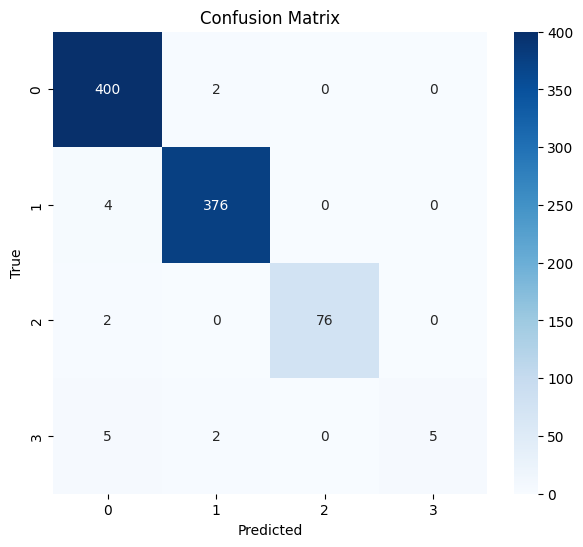

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       402
           1       0.99      0.99      0.99       380
           2       1.00      0.97      0.99        78
           3       1.00      0.42      0.59        12

    accuracy                           0.98       872
   macro avg       0.99      0.84      0.89       872
weighted avg       0.98      0.98      0.98       872



In [224]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

# Set model to eval mode
model.eval()

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batch prediction
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Collect predictions
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# Plot confusion matrix and classification report
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False, cmap='Blues')
    ax.set_ylim(len(labels), 0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

# Show results
print_confusion_matrix(all_targets, all_preds)


In [225]:
# Save only the weights
torch.save(model.state_dict(), "model/keypoint_classifier/keypoint_classifier_weights.pth")


In [226]:
from model.keypoint_classifier.keypoint_classifier_pyt import KeyPointClassifier

  # your model definition
import torch

# Rebuild the model architecture
model = KeypointClassifier()

# Load the saved weights
model.load_state_dict(torch.load("model/keypoint_classifier/keypoint_classifier_weights.pth"))
model.eval()


# Prepare input tensor (e.g., one sample from X_test)
input_tensor = torch.tensor([X_test[0]], dtype=torch.float32)

# Inference
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1).squeeze()
    predicted_class = torch.argmax(probs).item()

# Output results
print(probs.numpy())
print(predicted_class)


[1.5235033e-03 9.9834740e-01 6.8261119e-11 1.2909093e-04]
1


C:\Users\houci\AppData\Local\Temp\ipykernel_1704\3493685169.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/keypoint_classifier/